In [1]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

# Import libraries

In [2]:
import numpy as np
import math
from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns

from dtaidistance import (
    ed as dtai_ed,
    dtw as dtai_dtw,
    dtw_visualisation as dtai_dtw_visualisation,
)
from aeon.distances import (
    euclidean_distance as aeon_euclidean_distance,
    dtw_distance as aeon_dtw_distance,
    dtw_cost_matrix as aeon_dtw_cost_matrix,
)
from aeon.utils.numba.general import z_normalise_series
from aeon.transformations.collection import Normalizer

from sktime.distances import dtw_distance as sktime_dtw_distance
from pyts.metrics import dtw as pyts_dtw
from tslearn.metrics import (
    dtw as tslearn_dtw,
    dtw_path as tslearn_dtw_path,
    lb_envelope as tslearn_lb_envelope,
    lb_keogh as tslearn_lb_keogh,
)

import timeit
import time

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)


# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw.distance_measures import (
    dtw,
    ed,
    nearest_neighbor_interpolation,
    nearest_neighbor_interpolation_2d,
    usdtw,
    psdtw_prime,
    # psdtw_prime_w_counting,
    # psdtw_prime_lb_w_counting,
    # psdtw_prime_cache_flattened_array,
    psdtw_prime_cache_dict,
    # psdtw_prime_cache_dict_counting,
)

from ksfdtw.lower_bounds import (
    lb_dummy,
    lb_kim,
    lb_kim_first_last,
    lb_keogh,
    lb_keogh_envelope,
    lb_shen,
    lb_shen_legacy,
    lb_shen_without_last,
    lb_shen_without_last_legacy,
)

# Normalization

In [5]:
np.random.seed(42)  # For reproducibility
Q = np.random.random(150)
C = np.random.random(150)

print(Q.shape, C.shape)

(150,) (150,)


In [6]:
np.random.seed(42)
Q_3 = np.random.random(20)
C_3 = np.random.random(20)

In [7]:
Q_3_norm = z_normalise_series(Q_3)
C_3_norm = z_normalise_series(C_3)
print(Q_3_norm.mean(), Q_3_norm.std())  # ~0, ~1

-1.9984014443252818e-16 1.0


In [8]:
# https://www.aeon-toolkit.org/en/v1.1.0/api_reference/auto_generated/aeon.transformations.collection.Normalizer.html
normaliser = Normalizer()

In [9]:
Q_3

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914])

In [10]:
temp = np.array(Q_3.reshape(1, -1))
temp

array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
        0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
        0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
        0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914]])

In [11]:
temp = np.array([Q_3])
temp

array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
        0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
        0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
        0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914]])

In [12]:
temp_norm = normaliser.fit_transform(temp)
temp_norm

array([[[-0.27730331,  1.64394295,  0.91462239,  0.47001683,
         -1.00596069, -1.00604111, -1.33252392,  1.36205142,
          0.47820809,  0.83485688, -1.4575643 ,  1.70795028,
          1.24956743, -0.81816072, -0.91990978, -0.91464282,
         -0.51171077,  0.22359128, -0.08588732, -0.55510282]]])

In [13]:
mean = np.mean(temp_norm, axis=-1)
std = np.std(temp_norm, axis=-1)
print("Mean:", mean)
print("Std:", std)
assert np.allclose(mean, 0)
assert np.allclose(std, 1)

Mean: [[1.60982339e-16]]
Std: [[1.]]


# Distance Measures

## ED

In [14]:
np.random.seed(42)
Q4 = np.random.random(20)
C4 = np.random.random(20)

In [15]:
%%time
distance = dtai_dtw.distance(Q4, C4, window=4)
print(f"Distance: {distance}")

Distance: 0.9681751552406113
CPU times: user 269 μs, sys: 35 μs, total: 304 μs
Wall time: 267 μs


In [16]:
path = dtai_dtw.warping_path(Q4, C4, window=4)

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

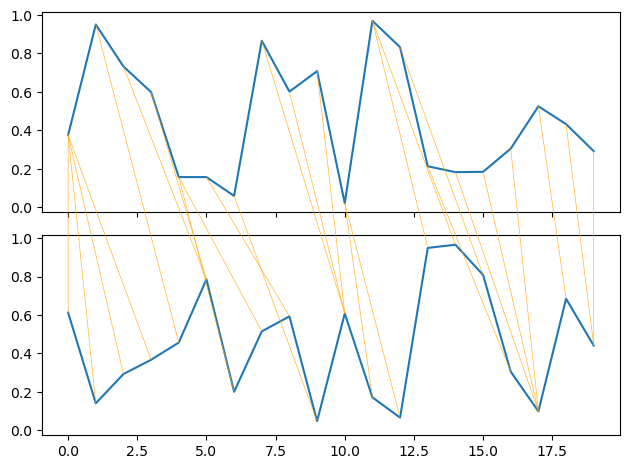

In [17]:
dtai_dtw_visualisation.plot_warping(Q4, C4, path)

In [18]:
# Test whether the local function is ED
dist = 0
for i in range(0, len(path)):
    dist += (Q4[path[i][0]] - C4[path[i][1]]) ** 2
print("Distance: ", np.sqrt(dist))

Distance:  0.9681751552406113


In [19]:
dist = dtai_ed.distance(Q, C)
print(dist)
dist = aeon_euclidean_distance(Q, C)
print(dist)
dist = ed(Q, C)
print(dist, math.sqrt(dist))
no_of_runs = 10
t_dtai_ed_distance = timeit.timeit(
    lambda: dtai_ed.distance(Q, C),
    number=no_of_runs,
)
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(Q, C),
    number=no_of_runs,
)
t_ksfdtw_ed_distance = timeit.timeit(
    lambda: ed(Q, C),
    number=no_of_runs,
)
t_dtai_ed_distance, t_aeon_dtw_distance, t_ksfdtw_ed_distance

5.013442513802633
5.013442513802632
25.134605839203658 5.013442513802633


(0.0002811669837683439, 0.004002500034403056, 4.916975740343332e-06)

(Slow) aeon, dtai, ksfdtw (Fast)

In [20]:
aeon_euclidean_distance(Q, C), math.sqrt(ed(Q, C))

(5.013442513802632, 5.013442513802633)

In [21]:
t_aeon_euclidean_distance = timeit.timeit(
    lambda: aeon_euclidean_distance(Q, C),
    number=no_of_runs,
)
t_ed = timeit.timeit(
    lambda: ed(Q, C),
    number=no_of_runs,
)
t_aeon_euclidean_distance, t_ed

(8.750008419156075e-06, 5.08397351950407e-06)

## DTW

In [22]:
dtai_dtw.distance_fast(Q, C, use_pruning=True), dtai_dtw.distance(Q, C)

(2.2092542447515657, 2.2092542447515657)

In [23]:
(dist := aeon_dtw_distance(Q, C), math.sqrt(dist))

(4.880804317952812, 2.2092542447515657)

In [24]:
(dist := sktime_dtw_distance(Q, C), math.sqrt(dist))

(4.880804317952812, 2.2092542447515657)

In [25]:
pyts_dtw(Q, C)

2.2092542447515657

In [26]:
tslearn_dtw(Q, C), tslearn_dtw(
    Q, C, global_constraint="sakoe_chiba", sakoe_chiba_radius=2
)

(2.2092542447515657, 3.1303137560231056)

In [27]:
aeon_dtw_distance(Q, C, window=0.2)

4.880804317952812

In [28]:
aeon_dtw_distance(Q, C, window=0.1), dtw(Q, C, 15)

(4.954591073485385, 4.954591073485385)

In [29]:
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(Q, C),
    number=no_of_runs,
)
t_sktime_dtw_distance = timeit.timeit(
    lambda: sktime_dtw_distance(Q, C),
    number=no_of_runs,
)
t_dtai_dtw_distance = timeit.timeit(
    lambda: dtai_dtw.distance(Q, C),
    number=no_of_runs,
)
t_dtai_dtw_distance_fast = timeit.timeit(
    lambda: dtai_dtw.distance_fast(Q, C, use_pruning=True),
    number=no_of_runs,
)
t_pyts_dtw_distance = timeit.timeit(
    lambda: pyts_dtw(Q, C),
    number=no_of_runs,
)
t_tslearn_dtw_distance = timeit.timeit(
    lambda: tslearn_dtw(Q, C),
    number=no_of_runs,
)
print(
    t_aeon_dtw_distance,
    t_sktime_dtw_distance,
    t_dtai_dtw_distance,
    t_dtai_dtw_distance_fast,
    t_pyts_dtw_distance,
    t_tslearn_dtw_distance,
)

0.001213249983265996 0.034921125043183565 0.16091724997386336 0.0013381250319071114 0.0022488749818876386 0.001785582979209721


(Slow) sktime, dtai (normal), pyts, tslearn, dtai (C), aeon (Fast)

In [30]:
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(Q, C, window=0.1),
    number=10000,
)
t_dtw = timeit.timeit(
    lambda: dtw(Q, C, r=15),
    number=10000,
)
t_aeon_dtw_distance, t_dtw

(0.3096080420073122, 0.3271827080170624)

### Cost Matrix

In [31]:
distance, paths = dtai_dtw.warping_paths_fast(
    Q[:15],
    C[:15],
    # window=3+1
)
best_path = dtai_dtw.best_path(paths)
print(distance)
print(len(Q[:15]), len(C[:15]))
print(paths)
print(best_path)

1.0296815023560584
15 15
[[0.                inf        inf        inf        inf        inf
         inf        inf        inf        inf        inf        inf
         inf        inf        inf        inf]
 [       inf 0.53372577 0.55052912 0.59650587 0.6074736  0.8616728
  0.87179828 0.92119232 0.9992126  1.00854754 1.06876331 1.06878467
  1.09942887 1.12952178 1.14097153 1.1758462 ]
 [       inf 0.53541112 0.88915744 0.97592381 0.75404341 0.60847737
  0.93404622 0.91522586 0.93455614 1.17553122 1.03279886 1.18595204
  1.11520609 1.14426828 1.20332636 1.42903688]
 [       inf 0.56368152 0.72742999 0.93479394 0.79209071 0.65923162
  0.78120715 0.78349705 0.78405696 0.92689458 0.92690228 0.99589023
  1.00086716 1.0056989  1.02466203 1.20901469]
 [       inf 0.64311244 0.66834664 0.80782959 0.79958338 0.76442731
  0.74950129 0.75309432 0.7705241  0.85090746 0.86071409 0.89114094
  0.89177594 0.89245746 0.89467016 1.02901577]
 [       inf 0.98968153 0.64851606 0.64861145 0.7292977  1.10

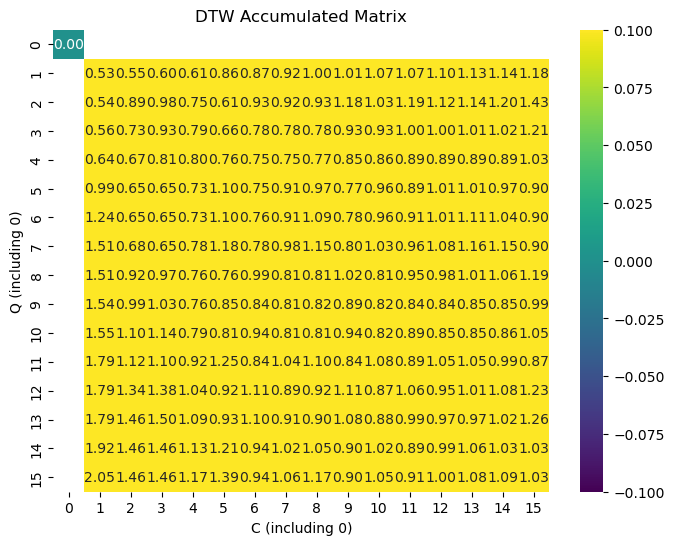

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(paths, annot=True, fmt=".2f", cmap="viridis")
plt.title("DTW Accumulated Matrix")
plt.xlabel("C (including 0)")
plt.ylabel("Q (including 0)")
plt.show()

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

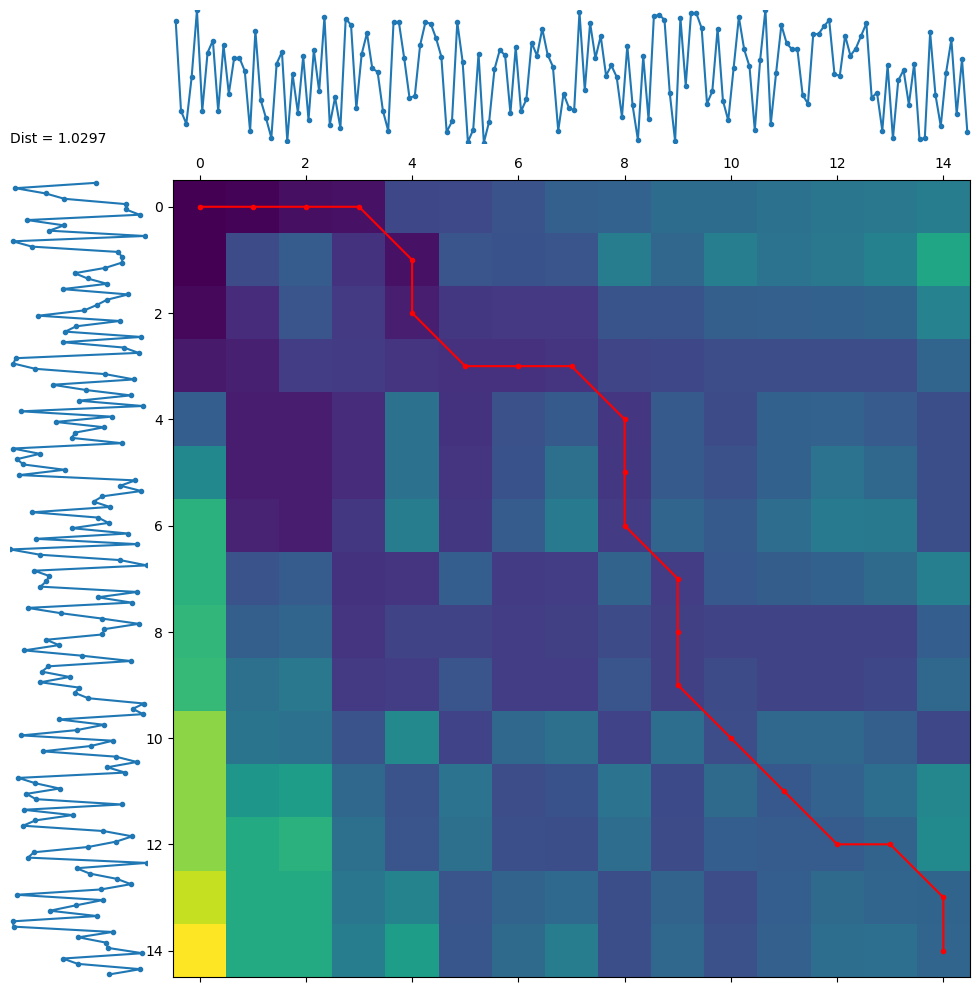

In [33]:
dtai_dtw_visualisation.plot_warpingpaths(Q, C, paths, best_path)

In [34]:
dist, mat = pyts_dtw(
    Q[:15],
    C[:15],
    method="sakoechiba",
    options={"window_size": 2},
    return_accumulated=True,
)
dist, mat

(1.169038139064468,
 array([[0.28486319, 0.30308232, 0.35581926,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [0.28666506, 0.79060095, 0.95242728, 0.56858147,        inf,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [0.31773686, 0.52915439, 0.87383971, 0.62740769, 0.6329231 ,
                inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [       inf, 0.44668722, 0.65258864, 0.63933358, 0.77717048,
         0.76008895,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf],
        [       inf,        inf, 0.44681096, 0.55798928, 1.24627822,
         0.76749125, 1.02646561,        inf,        inf,        inf,
          

In [35]:
tslearn_dtw(Q[:15], C[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)

1.169038139064468

In [36]:
aeon_dtw_cost_matrix(Q[:15], C[:15], window=0.1)

array([[0.28486319, 0.30308232,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [0.28666506, 0.79060095, 0.95242728,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf, 0.52915439, 0.87383971, 0.93266593,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf, 0.7350558 , 0.74698169, 0.89674448,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf,        inf, 0.84623412, 1.43527064,
        0.90414678,        inf,        inf,        inf,        inf,
               inf,        inf,        inf, 

## Interpolation

In [37]:
Q_300 = nearest_neighbor_interpolation(Q, 300)
Q_300[:10], len(Q_300)

(array([0.37454012, 0.37454012, 0.95071431, 0.95071431, 0.73199394,
        0.73199394, 0.59865848, 0.59865848, 0.15601864, 0.15601864]),
 300)

In [38]:
T_temp = np.array([1, 2, 3, 4, 5, 6])
nearest_neighbor_interpolation(T_temp, 8)

array([1, 2, 2, 3, 4, 5, 5, 6])

In [39]:
# Create test data
T_temp = np.random.rand(1_000_000)  # 1 million points
new_len = 200_000

# Benchmark
t_nearest_neighbor_interpolation_2d = timeit.timeit(
    lambda: nearest_neighbor_interpolation_2d(T_temp, new_len), number=5
)
t_nearest_neighbor_interpolation = timeit.timeit(
    lambda: nearest_neighbor_interpolation(T_temp, new_len), number=5
)

t_nearest_neighbor_interpolation_2d, t_nearest_neighbor_interpolation, t_nearest_neighbor_interpolation_2d / t_nearest_neighbor_interpolation

(0.18758941697888076, 0.0034965419908985496, 53.649982602003185)

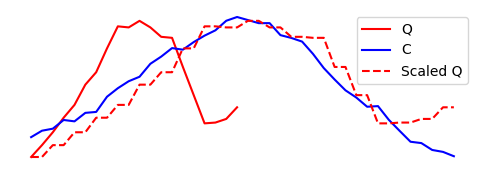

In [40]:
np.random.seed(0)
Q2 = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
C2 = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
Q2_scaled = nearest_neighbor_interpolation(Q2, len(C2))

# q = normalize(q)
# c = normalize(c)
# q_scaled = normalize(q_scaled)
Q2 = z_normalise_series(Q2)
C2 = z_normalise_series(C2)
Q2_scaled = z_normalise_series(Q2_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(6, 2))

ax1.plot(Q2, label="Q", color="red")
ax1.plot(C2, label="C", color="blue")
ax1.plot(Q2_scaled, label="Scaled Q", linestyle="--", color="red")

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis("off")
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
# plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()

## US, USDTW

In [41]:
# Data

In [42]:
C_x1 = np.linspace(0, 4 * np.pi, 100)
C_y1 = np.sin(C_x1) * 50 + 50  # Scale to range around 0~100
C_x2 = np.linspace(0, 1, 20)
C_y2 = np.piecewise(
    C_x2, [C_x2 < 0.5, C_x2 >= 0.5], [lambda x: 2 * x, lambda x: 2 * (1 - x)]
)
C_y2 = C_y2 * 50  # Scale it similarly
offset = C_y1[-1] - C_y2[0]
C_y2 = C_y2 + offset
C_US = np.concatenate([C_y1, C_y2])

In [43]:
Q_x = np.linspace(0, 4 * np.pi, 70)
Q_US = np.sin(Q_x) * 50 + 50  # Scale to range around 0~100

In [44]:
m = len(Q_US)
n = len(C_US)
m, n

(70, 120)

In [45]:
# Plot

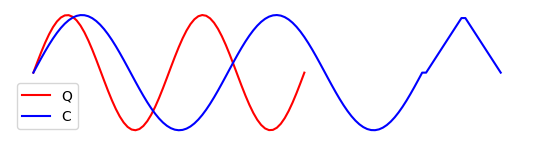

In [46]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(Q_US, color="red", label="Q")
plt.plot(C_US, color="blue", label="C")
# plt.title('C vs. Q')
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.axis("off")
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

Simply performing dtw on Q and C returns a bad result.

In [47]:
C_US_prefix = C_US[:100]
C_US_prefix_scaled = nearest_neighbor_interpolation(C_US_prefix, len(Q_US))

In [48]:
len(C_US_prefix_scaled)

70

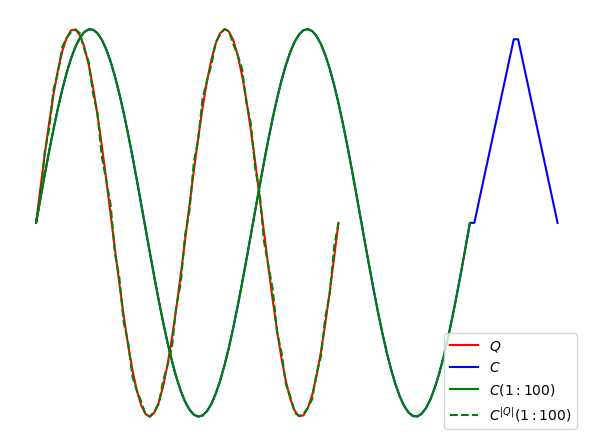

In [49]:
plt.plot(Q_US, color="red", label="$Q$")
plt.plot(C_US, color="blue", label="$C$")
plt.plot(C_US_prefix, color="green", label="$C(1:100)$")
plt.plot(C_US_prefix_scaled, linestyle="--", color="green", label="$C^{|Q|}(1:100)$")
plt.legend()
plt.tight_layout()
plt.axis("off")
plt.show()

As shown in the above graph, Q and scaled C(1:100) have a good match.

Test for USDTW. It select the most similar prefix $C(0:k)$ and compare it with $Q$.

In [50]:
l = 2  # scaling_factor
L = min(np.ceil(l * len(Q_US)), len(C_US))

best_so_far, best_k = usdtw(Q_US, C_US, l, L, 0.1, 0)
best_so_far, best_k, best_k / m  # best_k/m: best scaling factor
# k is the length of the prefix of C
# In this case, The prefix of C is longer than Q, about 1.42 times of the length of Q.

(26.180324399082302, 100, 1.4285714285714286)

## PSDTW

In [51]:
start_time = time.time()
psdtw_prime(Q, C, l=2, P=3, r=0.1)
print("Time used: {} sec".format(time.time() - start_time))

Time used: 5.886399984359741 sec


In [52]:
%%time
# Another way to time it
psdtw_prime(Q, C, l=2, P=3, r=0.1)

CPU times: user 5.56 s, sys: 42.6 ms, total: 5.6 s
Wall time: 5.63 s


(8.733158526176478, 9053711)

# Lower Bounds

In [53]:
# Sample sequences
np.random.seed(18)
Q_9 = np.sin(np.linspace(0, 4 * np.pi, 150))
C_9 = Q_9 + np.random.normal(0, 0.4, size=150)

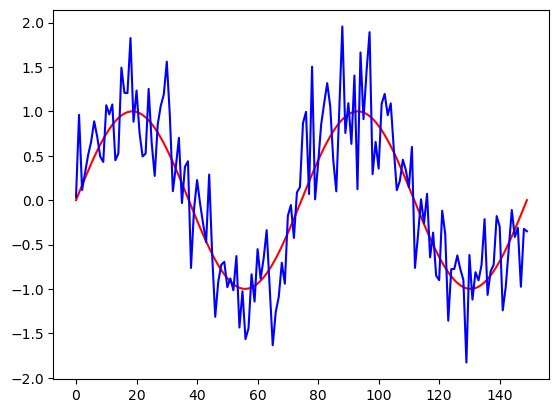

In [54]:
plt.plot(Q_9, label="Q", color="red")
plt.plot(C_9, label="C", color="blue")

In [55]:
%%time
psdtw_prime(Q_9, C_9, l=2, P=3, r=0.1, dist_method=1)
# (25.729020258608323, 9053711) total: 1min

CPU times: user 1min, sys: 423 ms, total: 1min
Wall time: 1min 1s


(25.729020258608323, 9053711)

In [56]:
# %%time
# psdtw_prime_cache_flattened_array(Q_9, C_9, l=2, P=3, r=0.1, dist_method=1)
# # It may even slower than the original psdtw_prime due to the cache overhead.
# # Its running time is similar to psdtw_prime.

In [57]:
%%time
%load_ext autoreload
%autoreload 2
from ksfdtw.distance_measures import psdtw_prime_cache_dict
dist, count = psdtw_prime_cache_dict(Q_9, C_9, l=2, P=3, r=0.1, dist_method=1)
print(f"Distance: {dist}, Count: {count}")
# Distance: 25.729020258608323, Count: 4603976 total: 34.3 s
# Distance: 25.729020258608323, Count: 3584399 total: 26.8 s
# Distance: 25.729020258608323, Count: 3050440 total: 27.4 s

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using psdtw_prime_cache_dict 2
Distance: 25.729020258608323, Count: 3050440
CPU times: user 27.5 s, sys: 355 ms, total: 27.8 s
Wall time: 28.2 s


In [58]:
(dist := aeon_dtw_distance(Q_9, C_9, window=1 / 75), math.sqrt(dist))

(22.559966618503562, 4.749733320777448)

In [59]:
dtai_dtw.distance(
    Q_9, C_9, window=2 + 1
)  # The definition of the window here is slightly different, always + 1

4.749733320777448

In [60]:
dtw(Q_9, C_9, r=2)

22.559966618503562

In [61]:
len(Q_9) * 0.1

15.0

Test for $LB_{Keogh}$ from `tslearn`

In [62]:
# lb_dummy(Q_9, C_9)

In [63]:
lb_kim(Q_9, C_9)

0.9137770853153537

In [64]:
lb_kim_first_last(Q_9, C_9)

0.12398967316885692

In [65]:
lb_keogh(Q_9, C_9, r=5), math.sqrt(lb_keogh(Q_9, C_9, r=5))

(10.866985271795862, 3.296511075636765)

In [66]:
# LB_Keogh
env_low, env_up = tslearn_lb_envelope(Q_9, radius=5)
tslearn_lb_keogh(ts_query=C_9, envelope_candidate=(env_low, env_up))

np.float64(3.2965110756367655)

In [67]:
# Another way to write it
tslearn_lb_keogh(ts_query=C_9, ts_candidate=Q_9, radius=5)

np.float64(3.2965110756367655)

In [68]:
tslearn_lb_keogh(ts_query=Q_9, ts_candidate=C_9, radius=5)

np.float64(0.11931729423380409)

In [69]:
lb_keogh(C_9, Q_9, r=5)

0.014236616703276177

In [70]:
math.sqrt(lb_shen_legacy(Q_9, C_9, l=1, r=5))

3.319244226793033

In [71]:
lb_shen_legacy(Q_9, C_9, l=1, r=5)

np.float64(11.017382237098879)

In [72]:
lb_shen(Q_9, C_9, l=1, r=5)

11.017382237098879

In [73]:
lb_kim(Q_9, C_9)

0.9137770853153537

In [74]:
lb_kim_first_last(Q_9, C_9)

0.12398967316885692

$LB_{Shen}$ lower bounds DTW.

In [75]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-09-05 11:15:22.800982

